In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

In [2]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
shap.initjs()

In [4]:
data = pd.read_parquet('/main/data/MVideo_2/dataset_main_7_w_1.parquet')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719968 entries, 0 to 1719967
Data columns (total 65 columns):
STORE_ID                                          category
PRODUCT_ID                                        category
DATE                                              datetime64[ns]
REGULAR_SALES_PRICE_INCL_TAX                      int32
MAINCATEGORY_ID                                   category
SUBCATEGORY_ID                                    category
REGION                                            category
INTERNET                                          category
WEEK(DATE)                                        category
MONTH(DATE)                                       category
category.SUM(trans.REVENUE_INCL_TAX_P)_W8         float32
category.STD(trans.UNITS_SOLD_P)_DIFF_W0          float32
category.STD(trans.REVENUE_INCL_TAX_P)_DIFF_W0    float32
category.MAX(trans.REVENUE_INCL_TAX_P)_MIN_2      float32
category.SUM(trans.REVENUE_INCL_TAX)_MAX_8        float32
cate

In [6]:
data_train = data[data.DATE < '2018-06-10']

In [7]:
data_train.shape[0]

1546018

In [8]:
data_train2 = data[data.DATE < '2018-07-08']

In [9]:
data_train2.shape[0]

1685178

In [10]:
data_val = data[(data.DATE >= '2018-06-10') & (data.DATE < '2018-07-08')]

In [11]:
data_val.shape[0]

139160

In [12]:
data_test = data[data.DATE == '2018-07-08']

In [13]:
data_test.shape[0]

34790

In [14]:
feat = [s for s in data.columns if s not in ['DATE', 'UNITS_SOLD_P1']]

In [15]:
dts = lgb.Dataset(data_train[feat], label = data_train.UNITS_SOLD_P1)

In [16]:
dts = dts.construct()

In [17]:
dtsv = dts.create_valid(data_val[feat], label = data_val.UNITS_SOLD_P1)

In [18]:
space = {
        'num_leaves': hp.quniform('num_leaves', 3, 9, 1),
        'min_data_in_leaf':hp.quniform('min_data_in_leaf', 10, 1000, 10),
        'min_sum_hessian_in_leaf': hp.quniform('min_sum_hessian_in_leaf', -5, 2, 1),
        'feature_fraction': hp.quniform('feature_fraction', 0.5, 1, 0.1),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.5, 1, 0.1),
        'bagging_freq': hp.quniform('bagging_freq', 0, 10, 1),
        'lambda_l2': hp.loguniform('lambda_l2', -9, 3),
       }

In [19]:
def get_params(space):
    params = dict()
    params['application'] = 'regression_l2'
    params['learning_rate'] = 0.03
    params['num_leaves'] = 2 ** int(space['num_leaves']) - 1
    params['min_data_in_leaf'] = int(space['min_data_in_leaf'])
    params['min_sum_hessian_in_leaf'] = 10 ** int(space['min_sum_hessian_in_leaf'])
    params['feature_fraction'] = np.round(space['feature_fraction'], 1)
    params['bagging_fraction'] = np.round(space['bagging_fraction'], 1)
    params['bagging_freq'] = int(space['bagging_freq'])
    params['lambda_l2'] = np.round(space['lambda_l2'], 4)
    params['metric'] = 'l2_root'
    return params

In [20]:
def objective_reg(space):
    params = get_params(space)
    bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'], num_boost_round = 10000,
                    early_stopping_rounds = 20)
    pred = bst.predict(data_val[feat])
    test_loss = mean_squared_error(data_val.UNITS_SOLD_P1, pred) ** 0.5
    return{'loss': test_loss, 'status': STATUS_OK, 'attachments': params}

In [22]:
N_HYPEROPT_PROBES = 30
HYPEROPT_ALGO = tpe.suggest #hyperopt.rand.suggest

trials = Trials()
best = fmin(fn=objective_reg,
            space=space,
            algo=HYPEROPT_ALGO,
            max_evals=N_HYPEROPT_PROBES,
            trials=trials,
            verbose=1)

[1]	Validation's rmse: 0.728828
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 0.724213
[3]	Validation's rmse: 0.719746
[4]	Validation's rmse: 0.715431
[5]	Validation's rmse: 0.71112
[6]	Validation's rmse: 0.707172
[7]	Validation's rmse: 0.703195
[8]	Validation's rmse: 0.699201
[9]	Validation's rmse: 0.695667
[10]	Validation's rmse: 0.692745
[11]	Validation's rmse: 0.689946
[12]	Validation's rmse: 0.686668
[13]	Validation's rmse: 0.683775
[14]	Validation's rmse: 0.680748
[15]	Validation's rmse: 0.678071
[16]	Validation's rmse: 0.675616
[17]	Validation's rmse: 0.673429
[18]	Validation's rmse: 0.670917
[19]	Validation's rmse: 0.669159
[20]	Validation's rmse: 0.666654
[21]	Validation's rmse: 0.664179
[22]	Validation's rmse: 0.662034
[23]	Validation's rmse: 0.660031
[24]	Validation's rmse: 0.65841
[25]	Validation's rmse: 0.656292
[26]	Validation's rmse: 0.654697
[27]	Validation's rmse: 0.653087
[28]	Validation's rmse: 0.651508
[29]	Validation's rmse: 0

[247]	Validation's rmse: 0.600639
[248]	Validation's rmse: 0.600581
[249]	Validation's rmse: 0.600566
[250]	Validation's rmse: 0.600558
[251]	Validation's rmse: 0.600553
[252]	Validation's rmse: 0.60054
[253]	Validation's rmse: 0.600551
[254]	Validation's rmse: 0.600521
[255]	Validation's rmse: 0.60047
[256]	Validation's rmse: 0.600459
[257]	Validation's rmse: 0.60045
[258]	Validation's rmse: 0.600427
[259]	Validation's rmse: 0.600431
[260]	Validation's rmse: 0.600443
[261]	Validation's rmse: 0.600452
[262]	Validation's rmse: 0.600465
[263]	Validation's rmse: 0.600457
[264]	Validation's rmse: 0.600434
[265]	Validation's rmse: 0.600378
[266]	Validation's rmse: 0.600351
[267]	Validation's rmse: 0.600334
[268]	Validation's rmse: 0.600326
[269]	Validation's rmse: 0.600283
[270]	Validation's rmse: 0.600299
[271]	Validation's rmse: 0.600295
[272]	Validation's rmse: 0.600297
[273]	Validation's rmse: 0.600286
[274]	Validation's rmse: 0.600221
[275]	Validation's rmse: 0.600188
[276]	Validation'

[165]	Validation's rmse: 0.600388
[166]	Validation's rmse: 0.60037
[167]	Validation's rmse: 0.600306
[168]	Validation's rmse: 0.600239
[169]	Validation's rmse: 0.600188
[170]	Validation's rmse: 0.600176
[171]	Validation's rmse: 0.600138
[172]	Validation's rmse: 0.600111
[173]	Validation's rmse: 0.600069
[174]	Validation's rmse: 0.599998
[175]	Validation's rmse: 0.59996
[176]	Validation's rmse: 0.599961
[177]	Validation's rmse: 0.599903
[178]	Validation's rmse: 0.599868
[179]	Validation's rmse: 0.599835
[180]	Validation's rmse: 0.599787
[181]	Validation's rmse: 0.599744
[182]	Validation's rmse: 0.599759
[183]	Validation's rmse: 0.599746
[184]	Validation's rmse: 0.599727
[185]	Validation's rmse: 0.599707
[186]	Validation's rmse: 0.5997
[187]	Validation's rmse: 0.599682
[188]	Validation's rmse: 0.599664
[189]	Validation's rmse: 0.5996
[190]	Validation's rmse: 0.599575
[191]	Validation's rmse: 0.599597
[192]	Validation's rmse: 0.599532
[193]	Validation's rmse: 0.599514
[194]	Validation's r

[34]	Validation's rmse: 0.630505
[35]	Validation's rmse: 0.629281
[36]	Validation's rmse: 0.628322
[37]	Validation's rmse: 0.62722
[38]	Validation's rmse: 0.626056
[39]	Validation's rmse: 0.625095
[40]	Validation's rmse: 0.624197
[41]	Validation's rmse: 0.623267
[42]	Validation's rmse: 0.622265
[43]	Validation's rmse: 0.621656
[44]	Validation's rmse: 0.620847
[45]	Validation's rmse: 0.620115
[46]	Validation's rmse: 0.619309
[47]	Validation's rmse: 0.618619
[48]	Validation's rmse: 0.618053
[49]	Validation's rmse: 0.617585
[50]	Validation's rmse: 0.616949
[51]	Validation's rmse: 0.616337
[52]	Validation's rmse: 0.615722
[53]	Validation's rmse: 0.6151
[54]	Validation's rmse: 0.6144
[55]	Validation's rmse: 0.613856
[56]	Validation's rmse: 0.613279
[57]	Validation's rmse: 0.612757
[58]	Validation's rmse: 0.612413
[59]	Validation's rmse: 0.611941
[60]	Validation's rmse: 0.611692
[61]	Validation's rmse: 0.611119
[62]	Validation's rmse: 0.610845
[63]	Validation's rmse: 0.610551
[64]	Validation

[120]	Validation's rmse: 0.600967
[121]	Validation's rmse: 0.600845
[122]	Validation's rmse: 0.60087
[123]	Validation's rmse: 0.600811
[124]	Validation's rmse: 0.600816
[125]	Validation's rmse: 0.600694
[126]	Validation's rmse: 0.600659
[127]	Validation's rmse: 0.60065
[128]	Validation's rmse: 0.600534
[129]	Validation's rmse: 0.600528
[130]	Validation's rmse: 0.600508
[131]	Validation's rmse: 0.600506
[132]	Validation's rmse: 0.600457
[133]	Validation's rmse: 0.600445
[134]	Validation's rmse: 0.600479
[135]	Validation's rmse: 0.600475
[136]	Validation's rmse: 0.600497
[137]	Validation's rmse: 0.600458
[138]	Validation's rmse: 0.600487
[139]	Validation's rmse: 0.600499
[140]	Validation's rmse: 0.600448
[141]	Validation's rmse: 0.600397
[142]	Validation's rmse: 0.600441
[143]	Validation's rmse: 0.600473
[144]	Validation's rmse: 0.600402
[145]	Validation's rmse: 0.600336
[146]	Validation's rmse: 0.600411
[147]	Validation's rmse: 0.600338
[148]	Validation's rmse: 0.600294
[149]	Validation

[91]	Validation's rmse: 0.607167
[92]	Validation's rmse: 0.606996
[93]	Validation's rmse: 0.606781
[94]	Validation's rmse: 0.606724
[95]	Validation's rmse: 0.606518
[96]	Validation's rmse: 0.606229
[97]	Validation's rmse: 0.606038
[98]	Validation's rmse: 0.605887
[99]	Validation's rmse: 0.605794
[100]	Validation's rmse: 0.605598
[101]	Validation's rmse: 0.605411
[102]	Validation's rmse: 0.605297
[103]	Validation's rmse: 0.605114
[104]	Validation's rmse: 0.604965
[105]	Validation's rmse: 0.604869
[106]	Validation's rmse: 0.604652
[107]	Validation's rmse: 0.604485
[108]	Validation's rmse: 0.604387
[109]	Validation's rmse: 0.604293
[110]	Validation's rmse: 0.604241
[111]	Validation's rmse: 0.604146
[112]	Validation's rmse: 0.604093
[113]	Validation's rmse: 0.60396
[114]	Validation's rmse: 0.603847
[115]	Validation's rmse: 0.603706
[116]	Validation's rmse: 0.60363
[117]	Validation's rmse: 0.603548
[118]	Validation's rmse: 0.603542
[119]	Validation's rmse: 0.603517
[120]	Validation's rmse: 

[339]	Validation's rmse: 0.59913
[340]	Validation's rmse: 0.599137
[341]	Validation's rmse: 0.599135
[342]	Validation's rmse: 0.599149
[343]	Validation's rmse: 0.599138
[344]	Validation's rmse: 0.599162
[345]	Validation's rmse: 0.599158
[346]	Validation's rmse: 0.599173
[347]	Validation's rmse: 0.599161
[348]	Validation's rmse: 0.599129
[349]	Validation's rmse: 0.599117
[350]	Validation's rmse: 0.599146
[351]	Validation's rmse: 0.599155
[352]	Validation's rmse: 0.599159
[353]	Validation's rmse: 0.599188
[354]	Validation's rmse: 0.599199
[355]	Validation's rmse: 0.599215
[356]	Validation's rmse: 0.599216
[357]	Validation's rmse: 0.599213
[358]	Validation's rmse: 0.599204
[359]	Validation's rmse: 0.599183
[360]	Validation's rmse: 0.599181
[361]	Validation's rmse: 0.599192
[362]	Validation's rmse: 0.599211
[363]	Validation's rmse: 0.599175
[364]	Validation's rmse: 0.599179
[365]	Validation's rmse: 0.59918
[366]	Validation's rmse: 0.599153
[367]	Validation's rmse: 0.599185
[368]	Validation

[211]	Validation's rmse: 0.600912
[212]	Validation's rmse: 0.600893
[213]	Validation's rmse: 0.600875
[214]	Validation's rmse: 0.600871
[215]	Validation's rmse: 0.600842
[216]	Validation's rmse: 0.60083
[217]	Validation's rmse: 0.600816
[218]	Validation's rmse: 0.600797
[219]	Validation's rmse: 0.60073
[220]	Validation's rmse: 0.600693
[221]	Validation's rmse: 0.600687
[222]	Validation's rmse: 0.600726
[223]	Validation's rmse: 0.600687
[224]	Validation's rmse: 0.600667
[225]	Validation's rmse: 0.600684
[226]	Validation's rmse: 0.600685
[227]	Validation's rmse: 0.600684
[228]	Validation's rmse: 0.600682
[229]	Validation's rmse: 0.600668
[230]	Validation's rmse: 0.600654
[231]	Validation's rmse: 0.600653
[232]	Validation's rmse: 0.600614
[233]	Validation's rmse: 0.600551
[234]	Validation's rmse: 0.600475
[235]	Validation's rmse: 0.600461
[236]	Validation's rmse: 0.600442
[237]	Validation's rmse: 0.600436
[238]	Validation's rmse: 0.600425
[239]	Validation's rmse: 0.600419
[240]	Validation

[110]	Validation's rmse: 0.601831
[111]	Validation's rmse: 0.601701
[112]	Validation's rmse: 0.601564
[113]	Validation's rmse: 0.601506
[114]	Validation's rmse: 0.60152
[115]	Validation's rmse: 0.601501
[116]	Validation's rmse: 0.601453
[117]	Validation's rmse: 0.601367
[118]	Validation's rmse: 0.601313
[119]	Validation's rmse: 0.601273
[120]	Validation's rmse: 0.601232
[121]	Validation's rmse: 0.601259
[122]	Validation's rmse: 0.601287
[123]	Validation's rmse: 0.601269
[124]	Validation's rmse: 0.601182
[125]	Validation's rmse: 0.601105
[126]	Validation's rmse: 0.601048
[127]	Validation's rmse: 0.600977
[128]	Validation's rmse: 0.600914
[129]	Validation's rmse: 0.600964
[130]	Validation's rmse: 0.600969
[131]	Validation's rmse: 0.600925
[132]	Validation's rmse: 0.600837
[133]	Validation's rmse: 0.600763
[134]	Validation's rmse: 0.600699
[135]	Validation's rmse: 0.600675
[136]	Validation's rmse: 0.600652
[137]	Validation's rmse: 0.600551
[138]	Validation's rmse: 0.600565
[139]	Validatio

[97]	Validation's rmse: 0.604781
[98]	Validation's rmse: 0.604663
[99]	Validation's rmse: 0.604594
[100]	Validation's rmse: 0.604478
[101]	Validation's rmse: 0.604284
[102]	Validation's rmse: 0.604105
[103]	Validation's rmse: 0.603963
[104]	Validation's rmse: 0.603892
[105]	Validation's rmse: 0.603895
[106]	Validation's rmse: 0.603773
[107]	Validation's rmse: 0.603715
[108]	Validation's rmse: 0.603589
[109]	Validation's rmse: 0.603536
[110]	Validation's rmse: 0.603427
[111]	Validation's rmse: 0.603314
[112]	Validation's rmse: 0.603257
[113]	Validation's rmse: 0.603232
[114]	Validation's rmse: 0.60311
[115]	Validation's rmse: 0.603067
[116]	Validation's rmse: 0.603006
[117]	Validation's rmse: 0.602894
[118]	Validation's rmse: 0.602856
[119]	Validation's rmse: 0.60274
[120]	Validation's rmse: 0.60273
[121]	Validation's rmse: 0.602755
[122]	Validation's rmse: 0.602764
[123]	Validation's rmse: 0.602806
[124]	Validation's rmse: 0.60285
[125]	Validation's rmse: 0.602869
[126]	Validation's rm

[140]	Validation's rmse: 0.601957
[141]	Validation's rmse: 0.601905
[142]	Validation's rmse: 0.601927
[143]	Validation's rmse: 0.601837
[144]	Validation's rmse: 0.601804
[145]	Validation's rmse: 0.601687
[146]	Validation's rmse: 0.601652
[147]	Validation's rmse: 0.601604
[148]	Validation's rmse: 0.6016
[149]	Validation's rmse: 0.601581
[150]	Validation's rmse: 0.60154
[151]	Validation's rmse: 0.601478
[152]	Validation's rmse: 0.601422
[153]	Validation's rmse: 0.601359
[154]	Validation's rmse: 0.601224
[155]	Validation's rmse: 0.601151
[156]	Validation's rmse: 0.600997
[157]	Validation's rmse: 0.600919
[158]	Validation's rmse: 0.600898
[159]	Validation's rmse: 0.600911
[160]	Validation's rmse: 0.600897
[161]	Validation's rmse: 0.600875
[162]	Validation's rmse: 0.600791
[163]	Validation's rmse: 0.600837
[164]	Validation's rmse: 0.600817
[165]	Validation's rmse: 0.600688
[166]	Validation's rmse: 0.600666
[167]	Validation's rmse: 0.600557
[168]	Validation's rmse: 0.600528
[169]	Validation'

[118]	Validation's rmse: 0.604047
[119]	Validation's rmse: 0.604039
[120]	Validation's rmse: 0.603917
[121]	Validation's rmse: 0.603862
[122]	Validation's rmse: 0.603791
[123]	Validation's rmse: 0.603757
[124]	Validation's rmse: 0.60371
[125]	Validation's rmse: 0.603637
[126]	Validation's rmse: 0.603589
[127]	Validation's rmse: 0.603553
[128]	Validation's rmse: 0.603475
[129]	Validation's rmse: 0.603511
[130]	Validation's rmse: 0.603476
[131]	Validation's rmse: 0.603457
[132]	Validation's rmse: 0.603433
[133]	Validation's rmse: 0.603464
[134]	Validation's rmse: 0.603393
[135]	Validation's rmse: 0.603363
[136]	Validation's rmse: 0.603321
[137]	Validation's rmse: 0.603395
[138]	Validation's rmse: 0.603364
[139]	Validation's rmse: 0.603365
[140]	Validation's rmse: 0.603257
[141]	Validation's rmse: 0.603263
[142]	Validation's rmse: 0.603263
[143]	Validation's rmse: 0.603431
[144]	Validation's rmse: 0.603418
[145]	Validation's rmse: 0.603393
[146]	Validation's rmse: 0.603375
[147]	Validatio

[170]	Validation's rmse: 0.601681
[171]	Validation's rmse: 0.601676
[172]	Validation's rmse: 0.601661
[173]	Validation's rmse: 0.601591
[174]	Validation's rmse: 0.60157
[175]	Validation's rmse: 0.601554
[176]	Validation's rmse: 0.601535
[177]	Validation's rmse: 0.601537
[178]	Validation's rmse: 0.601553
[179]	Validation's rmse: 0.601541
[180]	Validation's rmse: 0.601582
[181]	Validation's rmse: 0.60155
[182]	Validation's rmse: 0.601602
[183]	Validation's rmse: 0.6016
[184]	Validation's rmse: 0.601591
[185]	Validation's rmse: 0.601617
[186]	Validation's rmse: 0.601559
[187]	Validation's rmse: 0.60157
[188]	Validation's rmse: 0.601541
[189]	Validation's rmse: 0.601556
[190]	Validation's rmse: 0.601538
[191]	Validation's rmse: 0.601531
[192]	Validation's rmse: 0.601515
[193]	Validation's rmse: 0.601525
[194]	Validation's rmse: 0.601528
[195]	Validation's rmse: 0.601557
[196]	Validation's rmse: 0.601528
[197]	Validation's rmse: 0.601504
[198]	Validation's rmse: 0.60147
[199]	Validation's r

[197]	Validation's rmse: 0.600214
[198]	Validation's rmse: 0.600208
[199]	Validation's rmse: 0.600154
[200]	Validation's rmse: 0.600147
[201]	Validation's rmse: 0.600142
[202]	Validation's rmse: 0.600169
[203]	Validation's rmse: 0.600176
[204]	Validation's rmse: 0.600166
[205]	Validation's rmse: 0.600152
[206]	Validation's rmse: 0.600144
[207]	Validation's rmse: 0.60012
[208]	Validation's rmse: 0.600094
[209]	Validation's rmse: 0.600048
[210]	Validation's rmse: 0.600067
[211]	Validation's rmse: 0.60004
[212]	Validation's rmse: 0.600007
[213]	Validation's rmse: 0.59998
[214]	Validation's rmse: 0.599958
[215]	Validation's rmse: 0.599895
[216]	Validation's rmse: 0.59986
[217]	Validation's rmse: 0.599874
[218]	Validation's rmse: 0.599844
[219]	Validation's rmse: 0.599844
[220]	Validation's rmse: 0.599831
[221]	Validation's rmse: 0.599812
[222]	Validation's rmse: 0.599797
[223]	Validation's rmse: 0.599746
[224]	Validation's rmse: 0.599725
[225]	Validation's rmse: 0.599723
[226]	Validation's

[126]	Validation's rmse: 0.606338
[127]	Validation's rmse: 0.606103
[128]	Validation's rmse: 0.605906
[129]	Validation's rmse: 0.60588
[130]	Validation's rmse: 0.605822
[131]	Validation's rmse: 0.605744
[132]	Validation's rmse: 0.605612
[133]	Validation's rmse: 0.605462
[134]	Validation's rmse: 0.605371
[135]	Validation's rmse: 0.605278
[136]	Validation's rmse: 0.60523
[137]	Validation's rmse: 0.605282
[138]	Validation's rmse: 0.605246
[139]	Validation's rmse: 0.605126
[140]	Validation's rmse: 0.605004
[141]	Validation's rmse: 0.604923
[142]	Validation's rmse: 0.604924
[143]	Validation's rmse: 0.604881
[144]	Validation's rmse: 0.604777
[145]	Validation's rmse: 0.604694
[146]	Validation's rmse: 0.604606
[147]	Validation's rmse: 0.604506
[148]	Validation's rmse: 0.604428
[149]	Validation's rmse: 0.604358
[150]	Validation's rmse: 0.604288
[151]	Validation's rmse: 0.604263
[152]	Validation's rmse: 0.604169
[153]	Validation's rmse: 0.604139
[154]	Validation's rmse: 0.604092
[155]	Validation

[15]	Validation's rmse: 0.679241
[16]	Validation's rmse: 0.676689
[17]	Validation's rmse: 0.674503
[18]	Validation's rmse: 0.67185
[19]	Validation's rmse: 0.67018
[20]	Validation's rmse: 0.667909
[21]	Validation's rmse: 0.665365
[22]	Validation's rmse: 0.66299
[23]	Validation's rmse: 0.661137
[24]	Validation's rmse: 0.659487
[25]	Validation's rmse: 0.657242
[26]	Validation's rmse: 0.655433
[27]	Validation's rmse: 0.653855
[28]	Validation's rmse: 0.65213
[29]	Validation's rmse: 0.650627
[30]	Validation's rmse: 0.648925
[31]	Validation's rmse: 0.64739
[32]	Validation's rmse: 0.645778
[33]	Validation's rmse: 0.644227
[34]	Validation's rmse: 0.643157
[35]	Validation's rmse: 0.64143
[36]	Validation's rmse: 0.640129
[37]	Validation's rmse: 0.638777
[38]	Validation's rmse: 0.637497
[39]	Validation's rmse: 0.636215
[40]	Validation's rmse: 0.635304
[41]	Validation's rmse: 0.634413
[42]	Validation's rmse: 0.633406
[43]	Validation's rmse: 0.632406
[44]	Validation's rmse: 0.631111
[45]	Validation'

[264]	Validation's rmse: 0.600045
[265]	Validation's rmse: 0.600044
[266]	Validation's rmse: 0.600006
[267]	Validation's rmse: 0.599996
[268]	Validation's rmse: 0.599984
[269]	Validation's rmse: 0.600002
[270]	Validation's rmse: 0.600015
[271]	Validation's rmse: 0.600018
[272]	Validation's rmse: 0.600011
[273]	Validation's rmse: 0.600023
[274]	Validation's rmse: 0.599945
[275]	Validation's rmse: 0.599951
[276]	Validation's rmse: 0.599956
[277]	Validation's rmse: 0.599928
[278]	Validation's rmse: 0.599929
[279]	Validation's rmse: 0.599905
[280]	Validation's rmse: 0.599897
[281]	Validation's rmse: 0.599847
[282]	Validation's rmse: 0.599822
[283]	Validation's rmse: 0.599832
[284]	Validation's rmse: 0.599836
[285]	Validation's rmse: 0.59984
[286]	Validation's rmse: 0.599833
[287]	Validation's rmse: 0.59977
[288]	Validation's rmse: 0.599766
[289]	Validation's rmse: 0.599731
[290]	Validation's rmse: 0.599718
[291]	Validation's rmse: 0.599695
[292]	Validation's rmse: 0.599713
[293]	Validation

[509]	Validation's rmse: 0.598419
[510]	Validation's rmse: 0.598443
[511]	Validation's rmse: 0.598491
[512]	Validation's rmse: 0.598503
[513]	Validation's rmse: 0.598479
[514]	Validation's rmse: 0.598468
[515]	Validation's rmse: 0.598476
[516]	Validation's rmse: 0.598471
[517]	Validation's rmse: 0.598471
[518]	Validation's rmse: 0.598481
[519]	Validation's rmse: 0.598471
[520]	Validation's rmse: 0.598475
[521]	Validation's rmse: 0.598508
[522]	Validation's rmse: 0.598523
[523]	Validation's rmse: 0.598576
[524]	Validation's rmse: 0.598554
[525]	Validation's rmse: 0.598552
[526]	Validation's rmse: 0.598549
[527]	Validation's rmse: 0.598548
[528]	Validation's rmse: 0.598538
Early stopping, best iteration is:
[508]	Validation's rmse: 0.598408
[1]	Validation's rmse: 0.729516
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 0.725247
[3]	Validation's rmse: 0.721181
[4]	Validation's rmse: 0.717354
[5]	Validation's rmse: 0.713579
[6]	Validation's rmse: 0.7102

[230]	Validation's rmse: 0.603675
[231]	Validation's rmse: 0.603612
[232]	Validation's rmse: 0.603583
[233]	Validation's rmse: 0.603579
[234]	Validation's rmse: 0.603561
[235]	Validation's rmse: 0.603529
[236]	Validation's rmse: 0.603508
[237]	Validation's rmse: 0.603465
[238]	Validation's rmse: 0.603429
[239]	Validation's rmse: 0.603396
[240]	Validation's rmse: 0.603439
[241]	Validation's rmse: 0.603418
[242]	Validation's rmse: 0.603381
[243]	Validation's rmse: 0.603368
[244]	Validation's rmse: 0.60341
[245]	Validation's rmse: 0.603384
[246]	Validation's rmse: 0.603358
[247]	Validation's rmse: 0.603362
[248]	Validation's rmse: 0.603368
[249]	Validation's rmse: 0.603349
[250]	Validation's rmse: 0.603359
[251]	Validation's rmse: 0.603358
[252]	Validation's rmse: 0.603365
[253]	Validation's rmse: 0.603342
[254]	Validation's rmse: 0.603317
[255]	Validation's rmse: 0.6033
[256]	Validation's rmse: 0.603283
[257]	Validation's rmse: 0.603266
[258]	Validation's rmse: 0.603236
[259]	Validation'

[481]	Validation's rmse: 0.600984
[482]	Validation's rmse: 0.600987
[483]	Validation's rmse: 0.600971
[484]	Validation's rmse: 0.600947
[485]	Validation's rmse: 0.600934
[486]	Validation's rmse: 0.600925
[487]	Validation's rmse: 0.600913
[488]	Validation's rmse: 0.600924
[489]	Validation's rmse: 0.600903
[490]	Validation's rmse: 0.600894
[491]	Validation's rmse: 0.60088
[492]	Validation's rmse: 0.600885
[493]	Validation's rmse: 0.60088
[494]	Validation's rmse: 0.600875
[495]	Validation's rmse: 0.600853
[496]	Validation's rmse: 0.600839
[497]	Validation's rmse: 0.60083
[498]	Validation's rmse: 0.600825
[499]	Validation's rmse: 0.600842
[500]	Validation's rmse: 0.600848
[501]	Validation's rmse: 0.600846
[502]	Validation's rmse: 0.600823
[503]	Validation's rmse: 0.600824
[504]	Validation's rmse: 0.60081
[505]	Validation's rmse: 0.60081
[506]	Validation's rmse: 0.600811
[507]	Validation's rmse: 0.600794
[508]	Validation's rmse: 0.60076
[509]	Validation's rmse: 0.600784
[510]	Validation's r

[99]	Validation's rmse: 0.609579
[100]	Validation's rmse: 0.609508
[101]	Validation's rmse: 0.609345
[102]	Validation's rmse: 0.609282
[103]	Validation's rmse: 0.609041
[104]	Validation's rmse: 0.608973
[105]	Validation's rmse: 0.608783
[106]	Validation's rmse: 0.608697
[107]	Validation's rmse: 0.608589
[108]	Validation's rmse: 0.608451
[109]	Validation's rmse: 0.608049
[110]	Validation's rmse: 0.60793
[111]	Validation's rmse: 0.607698
[112]	Validation's rmse: 0.607584
[113]	Validation's rmse: 0.607474
[114]	Validation's rmse: 0.60735
[115]	Validation's rmse: 0.607258
[116]	Validation's rmse: 0.607132
[117]	Validation's rmse: 0.6071
[118]	Validation's rmse: 0.607011
[119]	Validation's rmse: 0.606893
[120]	Validation's rmse: 0.606798
[121]	Validation's rmse: 0.606751
[122]	Validation's rmse: 0.606691
[123]	Validation's rmse: 0.606598
[124]	Validation's rmse: 0.606514
[125]	Validation's rmse: 0.606401
[126]	Validation's rmse: 0.60632
[127]	Validation's rmse: 0.606249
[128]	Validation's r

[350]	Validation's rmse: 0.600159
[351]	Validation's rmse: 0.600166
[352]	Validation's rmse: 0.600094
[353]	Validation's rmse: 0.6001
[354]	Validation's rmse: 0.600088
[355]	Validation's rmse: 0.600072
[356]	Validation's rmse: 0.600085
[357]	Validation's rmse: 0.60007
[358]	Validation's rmse: 0.60007
[359]	Validation's rmse: 0.600071
[360]	Validation's rmse: 0.60008
[361]	Validation's rmse: 0.600086
[362]	Validation's rmse: 0.600073
[363]	Validation's rmse: 0.600077
[364]	Validation's rmse: 0.600089
[365]	Validation's rmse: 0.600098
[366]	Validation's rmse: 0.600041
[367]	Validation's rmse: 0.600059
[368]	Validation's rmse: 0.600064
[369]	Validation's rmse: 0.600072
[370]	Validation's rmse: 0.600066
[371]	Validation's rmse: 0.600037
[372]	Validation's rmse: 0.600033
[373]	Validation's rmse: 0.600025
[374]	Validation's rmse: 0.600001
[375]	Validation's rmse: 0.599971
[376]	Validation's rmse: 0.599955
[377]	Validation's rmse: 0.599962
[378]	Validation's rmse: 0.599961
[379]	Validation's 

[137]	Validation's rmse: 0.603318
[138]	Validation's rmse: 0.603176
[139]	Validation's rmse: 0.603152
[140]	Validation's rmse: 0.603189
[141]	Validation's rmse: 0.603193
[142]	Validation's rmse: 0.603168
[143]	Validation's rmse: 0.603149
[144]	Validation's rmse: 0.603169
[145]	Validation's rmse: 0.603139
[146]	Validation's rmse: 0.60307
[147]	Validation's rmse: 0.602999
[148]	Validation's rmse: 0.602979
[149]	Validation's rmse: 0.603021
[150]	Validation's rmse: 0.603003
[151]	Validation's rmse: 0.603035
[152]	Validation's rmse: 0.603026
[153]	Validation's rmse: 0.603039
[154]	Validation's rmse: 0.603053
[155]	Validation's rmse: 0.603063
[156]	Validation's rmse: 0.603038
[157]	Validation's rmse: 0.603087
[158]	Validation's rmse: 0.603022
[159]	Validation's rmse: 0.603039
[160]	Validation's rmse: 0.602866
[161]	Validation's rmse: 0.60286
[162]	Validation's rmse: 0.602859
[163]	Validation's rmse: 0.602846
[164]	Validation's rmse: 0.602816
[165]	Validation's rmse: 0.602817
[166]	Validation

[120]	Validation's rmse: 0.607728
[121]	Validation's rmse: 0.607644
[122]	Validation's rmse: 0.607537
[123]	Validation's rmse: 0.607465
[124]	Validation's rmse: 0.607334
[125]	Validation's rmse: 0.607403
[126]	Validation's rmse: 0.607314
[127]	Validation's rmse: 0.607209
[128]	Validation's rmse: 0.60712
[129]	Validation's rmse: 0.607065
[130]	Validation's rmse: 0.606929
[131]	Validation's rmse: 0.60692
[132]	Validation's rmse: 0.606873
[133]	Validation's rmse: 0.606839
[134]	Validation's rmse: 0.606885
[135]	Validation's rmse: 0.606873
[136]	Validation's rmse: 0.6068
[137]	Validation's rmse: 0.60671
[138]	Validation's rmse: 0.606569
[139]	Validation's rmse: 0.606497
[140]	Validation's rmse: 0.606266
[141]	Validation's rmse: 0.606311
[142]	Validation's rmse: 0.606178
[143]	Validation's rmse: 0.606143
[144]	Validation's rmse: 0.606066
[145]	Validation's rmse: 0.606022
[146]	Validation's rmse: 0.605961
[147]	Validation's rmse: 0.605927
[148]	Validation's rmse: 0.605862
[149]	Validation's 

[92]	Validation's rmse: 0.603434
[93]	Validation's rmse: 0.603225
[94]	Validation's rmse: 0.603231
[95]	Validation's rmse: 0.603094
[96]	Validation's rmse: 0.602845
[97]	Validation's rmse: 0.602596
[98]	Validation's rmse: 0.602472
[99]	Validation's rmse: 0.602285
[100]	Validation's rmse: 0.602162
[101]	Validation's rmse: 0.602129
[102]	Validation's rmse: 0.601973
[103]	Validation's rmse: 0.601934
[104]	Validation's rmse: 0.601938
[105]	Validation's rmse: 0.601835
[106]	Validation's rmse: 0.601714
[107]	Validation's rmse: 0.601665
[108]	Validation's rmse: 0.601719
[109]	Validation's rmse: 0.601607
[110]	Validation's rmse: 0.601565
[111]	Validation's rmse: 0.601497
[112]	Validation's rmse: 0.601346
[113]	Validation's rmse: 0.60132
[114]	Validation's rmse: 0.601267
[115]	Validation's rmse: 0.601238
[116]	Validation's rmse: 0.601234
[117]	Validation's rmse: 0.601318
[118]	Validation's rmse: 0.601263
[119]	Validation's rmse: 0.601319
[120]	Validation's rmse: 0.601386
[121]	Validation's rmse

[76]	Validation's rmse: 0.605369
[77]	Validation's rmse: 0.605163
[78]	Validation's rmse: 0.604981
[79]	Validation's rmse: 0.604622
[80]	Validation's rmse: 0.604308
[81]	Validation's rmse: 0.604117
[82]	Validation's rmse: 0.603935
[83]	Validation's rmse: 0.603851
[84]	Validation's rmse: 0.60373
[85]	Validation's rmse: 0.603516
[86]	Validation's rmse: 0.603333
[87]	Validation's rmse: 0.603281
[88]	Validation's rmse: 0.603135
[89]	Validation's rmse: 0.603067
[90]	Validation's rmse: 0.602924
[91]	Validation's rmse: 0.602599
[92]	Validation's rmse: 0.602492
[93]	Validation's rmse: 0.60232
[94]	Validation's rmse: 0.602152
[95]	Validation's rmse: 0.601941
[96]	Validation's rmse: 0.601773
[97]	Validation's rmse: 0.601659
[98]	Validation's rmse: 0.601558
[99]	Validation's rmse: 0.601429
[100]	Validation's rmse: 0.601342
[101]	Validation's rmse: 0.601275
[102]	Validation's rmse: 0.601145
[103]	Validation's rmse: 0.601041
[104]	Validation's rmse: 0.600945
[105]	Validation's rmse: 0.600793
[106]	

[49]	Validation's rmse: 0.619548
[50]	Validation's rmse: 0.61911
[51]	Validation's rmse: 0.618757
[52]	Validation's rmse: 0.618035
[53]	Validation's rmse: 0.617468
[54]	Validation's rmse: 0.616842
[55]	Validation's rmse: 0.615793
[56]	Validation's rmse: 0.615041
[57]	Validation's rmse: 0.614301
[58]	Validation's rmse: 0.613793
[59]	Validation's rmse: 0.613234
[60]	Validation's rmse: 0.612777
[61]	Validation's rmse: 0.612194
[62]	Validation's rmse: 0.611827
[63]	Validation's rmse: 0.611349
[64]	Validation's rmse: 0.610889
[65]	Validation's rmse: 0.610629
[66]	Validation's rmse: 0.610298
[67]	Validation's rmse: 0.609971
[68]	Validation's rmse: 0.609685
[69]	Validation's rmse: 0.609396
[70]	Validation's rmse: 0.609042
[71]	Validation's rmse: 0.608828
[72]	Validation's rmse: 0.608655
[73]	Validation's rmse: 0.608464
[74]	Validation's rmse: 0.608232
[75]	Validation's rmse: 0.607777
[76]	Validation's rmse: 0.607465
[77]	Validation's rmse: 0.60711
[78]	Validation's rmse: 0.60686
[79]	Validati

[56]	Validation's rmse: 0.614614
[57]	Validation's rmse: 0.613948
[58]	Validation's rmse: 0.613437
[59]	Validation's rmse: 0.612913
[60]	Validation's rmse: 0.612556
[61]	Validation's rmse: 0.611958
[62]	Validation's rmse: 0.611575
[63]	Validation's rmse: 0.61109
[64]	Validation's rmse: 0.61066
[65]	Validation's rmse: 0.610444
[66]	Validation's rmse: 0.610121
[67]	Validation's rmse: 0.609814
[68]	Validation's rmse: 0.609585
[69]	Validation's rmse: 0.60935
[70]	Validation's rmse: 0.609008
[71]	Validation's rmse: 0.608784
[72]	Validation's rmse: 0.608664
[73]	Validation's rmse: 0.608397
[74]	Validation's rmse: 0.608174
[75]	Validation's rmse: 0.607751
[76]	Validation's rmse: 0.607545
[77]	Validation's rmse: 0.607189
[78]	Validation's rmse: 0.606929
[79]	Validation's rmse: 0.606717
[80]	Validation's rmse: 0.606324
[81]	Validation's rmse: 0.606128
[82]	Validation's rmse: 0.605857
[83]	Validation's rmse: 0.605556
[84]	Validation's rmse: 0.605382
[85]	Validation's rmse: 0.605141
[86]	Validati

[10]	Validation's rmse: 0.68954
[11]	Validation's rmse: 0.686682
[12]	Validation's rmse: 0.683089
[13]	Validation's rmse: 0.680154
[14]	Validation's rmse: 0.676643
[15]	Validation's rmse: 0.673533
[16]	Validation's rmse: 0.670843
[17]	Validation's rmse: 0.66859
[18]	Validation's rmse: 0.665732
[19]	Validation's rmse: 0.663764
[20]	Validation's rmse: 0.661208
[21]	Validation's rmse: 0.659406
[22]	Validation's rmse: 0.657503
[23]	Validation's rmse: 0.655384
[24]	Validation's rmse: 0.653849
[25]	Validation's rmse: 0.652208
[26]	Validation's rmse: 0.650262
[27]	Validation's rmse: 0.648263
[28]	Validation's rmse: 0.646637
[29]	Validation's rmse: 0.64523
[30]	Validation's rmse: 0.643604
[31]	Validation's rmse: 0.642329
[32]	Validation's rmse: 0.640484
[33]	Validation's rmse: 0.637789
[34]	Validation's rmse: 0.636769
[35]	Validation's rmse: 0.634944
[36]	Validation's rmse: 0.63332
[37]	Validation's rmse: 0.632156
[38]	Validation's rmse: 0.630702
[39]	Validation's rmse: 0.629798
[40]	Validatio

[261]	Validation's rmse: 0.598823
[262]	Validation's rmse: 0.598838
[263]	Validation's rmse: 0.598807
[264]	Validation's rmse: 0.598818
[265]	Validation's rmse: 0.598752
[266]	Validation's rmse: 0.598836
[267]	Validation's rmse: 0.59882
[268]	Validation's rmse: 0.598811
[269]	Validation's rmse: 0.598839
[270]	Validation's rmse: 0.598819
[271]	Validation's rmse: 0.598814
[272]	Validation's rmse: 0.598794
[273]	Validation's rmse: 0.598786
[274]	Validation's rmse: 0.598838
[275]	Validation's rmse: 0.598777
[276]	Validation's rmse: 0.598758
[277]	Validation's rmse: 0.598715
[278]	Validation's rmse: 0.598761
[279]	Validation's rmse: 0.598778
[280]	Validation's rmse: 0.598773
[281]	Validation's rmse: 0.598766
[282]	Validation's rmse: 0.598742
[283]	Validation's rmse: 0.598701
[284]	Validation's rmse: 0.598666
[285]	Validation's rmse: 0.59866
[286]	Validation's rmse: 0.598642
[287]	Validation's rmse: 0.598621
[288]	Validation's rmse: 0.598622
[289]	Validation's rmse: 0.598606
[290]	Validation

[191]	Validation's rmse: 0.606088
[192]	Validation's rmse: 0.606142
[193]	Validation's rmse: 0.606107
[194]	Validation's rmse: 0.606011
[195]	Validation's rmse: 0.605966
[196]	Validation's rmse: 0.60591
[197]	Validation's rmse: 0.605846
[198]	Validation's rmse: 0.60591
[199]	Validation's rmse: 0.605876
[200]	Validation's rmse: 0.605821
[201]	Validation's rmse: 0.605778
[202]	Validation's rmse: 0.60579
[203]	Validation's rmse: 0.605742
[204]	Validation's rmse: 0.605727
[205]	Validation's rmse: 0.60566
[206]	Validation's rmse: 0.605584
[207]	Validation's rmse: 0.605505
[208]	Validation's rmse: 0.605507
[209]	Validation's rmse: 0.605494
[210]	Validation's rmse: 0.605447
[211]	Validation's rmse: 0.605403
[212]	Validation's rmse: 0.605364
[213]	Validation's rmse: 0.605328
[214]	Validation's rmse: 0.605285
[215]	Validation's rmse: 0.605275
[216]	Validation's rmse: 0.605245
[217]	Validation's rmse: 0.605195
[218]	Validation's rmse: 0.605183
[219]	Validation's rmse: 0.605178
[220]	Validation's

[442]	Validation's rmse: 0.602712
[443]	Validation's rmse: 0.602705
[444]	Validation's rmse: 0.602691
[445]	Validation's rmse: 0.602682
[446]	Validation's rmse: 0.602693
[447]	Validation's rmse: 0.602732
[448]	Validation's rmse: 0.602697
[449]	Validation's rmse: 0.60271
[450]	Validation's rmse: 0.602707
[451]	Validation's rmse: 0.602718
[452]	Validation's rmse: 0.602703
[453]	Validation's rmse: 0.602639
[454]	Validation's rmse: 0.602612
[455]	Validation's rmse: 0.602602
[456]	Validation's rmse: 0.602585
[457]	Validation's rmse: 0.602586
[458]	Validation's rmse: 0.602586
[459]	Validation's rmse: 0.602582
[460]	Validation's rmse: 0.602576
[461]	Validation's rmse: 0.602574
[462]	Validation's rmse: 0.602566
[463]	Validation's rmse: 0.602562
[464]	Validation's rmse: 0.602544
[465]	Validation's rmse: 0.60249
[466]	Validation's rmse: 0.602488
[467]	Validation's rmse: 0.602499
[468]	Validation's rmse: 0.602472
[469]	Validation's rmse: 0.602456
[470]	Validation's rmse: 0.602443
[471]	Validation

[689]	Validation's rmse: 0.601225
[690]	Validation's rmse: 0.60123
[691]	Validation's rmse: 0.601226
[692]	Validation's rmse: 0.601219
[693]	Validation's rmse: 0.601188
[694]	Validation's rmse: 0.60119
[695]	Validation's rmse: 0.601195
[696]	Validation's rmse: 0.601212
[697]	Validation's rmse: 0.601212
[698]	Validation's rmse: 0.601213
[699]	Validation's rmse: 0.601214
[700]	Validation's rmse: 0.601216
[701]	Validation's rmse: 0.601208
[702]	Validation's rmse: 0.601202
[703]	Validation's rmse: 0.601203
[704]	Validation's rmse: 0.601211
[705]	Validation's rmse: 0.601214
[706]	Validation's rmse: 0.601214
[707]	Validation's rmse: 0.601193
[708]	Validation's rmse: 0.601191
[709]	Validation's rmse: 0.601201
[710]	Validation's rmse: 0.601204
[711]	Validation's rmse: 0.601204
[712]	Validation's rmse: 0.601201
[713]	Validation's rmse: 0.601196
Early stopping, best iteration is:
[693]	Validation's rmse: 0.601188
[1]	Validation's rmse: 0.728354
Training until validation scores don't improve for 

[1]	Validation's rmse: 0.728502
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 0.723868
[3]	Validation's rmse: 0.719363
[4]	Validation's rmse: 0.714562
[5]	Validation's rmse: 0.71
[6]	Validation's rmse: 0.706018
[7]	Validation's rmse: 0.701774
[8]	Validation's rmse: 0.697698
[9]	Validation's rmse: 0.694195
[10]	Validation's rmse: 0.691094
[11]	Validation's rmse: 0.688249
[12]	Validation's rmse: 0.684683
[13]	Validation's rmse: 0.681352
[14]	Validation's rmse: 0.677797
[15]	Validation's rmse: 0.675031
[16]	Validation's rmse: 0.672328
[17]	Validation's rmse: 0.669898
[18]	Validation's rmse: 0.667159
[19]	Validation's rmse: 0.665332
[20]	Validation's rmse: 0.6631
[21]	Validation's rmse: 0.660624
[22]	Validation's rmse: 0.658429
[23]	Validation's rmse: 0.656498
[24]	Validation's rmse: 0.654911
[25]	Validation's rmse: 0.653047
[26]	Validation's rmse: 0.651326
[27]	Validation's rmse: 0.649464
[28]	Validation's rmse: 0.647806
[29]	Validation's rmse: 0.646

[246]	Validation's rmse: 0.599154
[247]	Validation's rmse: 0.599192
[248]	Validation's rmse: 0.599201
[249]	Validation's rmse: 0.599198
[250]	Validation's rmse: 0.599191
[251]	Validation's rmse: 0.599203
[252]	Validation's rmse: 0.599179
[253]	Validation's rmse: 0.599181
[254]	Validation's rmse: 0.599162
[255]	Validation's rmse: 0.599152
[256]	Validation's rmse: 0.599166
[257]	Validation's rmse: 0.59917
[258]	Validation's rmse: 0.599175
Early stopping, best iteration is:
[238]	Validation's rmse: 0.599063
[1]	Validation's rmse: 0.728359
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 0.722628
[3]	Validation's rmse: 0.718117
[4]	Validation's rmse: 0.712838
[5]	Validation's rmse: 0.709014
[6]	Validation's rmse: 0.704908
[7]	Validation's rmse: 0.70007
[8]	Validation's rmse: 0.695715
[9]	Validation's rmse: 0.69194
[10]	Validation's rmse: 0.688624
[11]	Validation's rmse: 0.685732
[12]	Validation's rmse: 0.681926
[13]	Validation's rmse: 0.678937
[14]	Valid

[16]	Validation's rmse: 0.668306
[17]	Validation's rmse: 0.665535
[18]	Validation's rmse: 0.662911
[19]	Validation's rmse: 0.660977
[20]	Validation's rmse: 0.658411
[21]	Validation's rmse: 0.65611
[22]	Validation's rmse: 0.653619
[23]	Validation's rmse: 0.651686
[24]	Validation's rmse: 0.649718
[25]	Validation's rmse: 0.647932
[26]	Validation's rmse: 0.646332
[27]	Validation's rmse: 0.644682
[28]	Validation's rmse: 0.643132
[29]	Validation's rmse: 0.641551
[30]	Validation's rmse: 0.639893
[31]	Validation's rmse: 0.638385
[32]	Validation's rmse: 0.637113
[33]	Validation's rmse: 0.635843
[34]	Validation's rmse: 0.634702
[35]	Validation's rmse: 0.633341
[36]	Validation's rmse: 0.63217
[37]	Validation's rmse: 0.630977
[38]	Validation's rmse: 0.629738
[39]	Validation's rmse: 0.628764
[40]	Validation's rmse: 0.62773
[41]	Validation's rmse: 0.626821
[42]	Validation's rmse: 0.62579
[43]	Validation's rmse: 0.625255
[44]	Validation's rmse: 0.624697
[45]	Validation's rmse: 0.623805
[46]	Validatio

[264]	Validation's rmse: 0.598165
[265]	Validation's rmse: 0.59817
[266]	Validation's rmse: 0.598152
[267]	Validation's rmse: 0.598132
[268]	Validation's rmse: 0.59812
[269]	Validation's rmse: 0.598195
[270]	Validation's rmse: 0.59823
[271]	Validation's rmse: 0.598226
[272]	Validation's rmse: 0.598202
[273]	Validation's rmse: 0.598217
[274]	Validation's rmse: 0.598211
[275]	Validation's rmse: 0.598191
[276]	Validation's rmse: 0.598188
[277]	Validation's rmse: 0.598202
[278]	Validation's rmse: 0.598171
[279]	Validation's rmse: 0.598172
[280]	Validation's rmse: 0.598172
[281]	Validation's rmse: 0.598162
[282]	Validation's rmse: 0.598177
[283]	Validation's rmse: 0.598124
[284]	Validation's rmse: 0.598121
[285]	Validation's rmse: 0.598194
[286]	Validation's rmse: 0.598166
[287]	Validation's rmse: 0.598198
[288]	Validation's rmse: 0.598172
Early stopping, best iteration is:
[268]	Validation's rmse: 0.59812
[1]	Validation's rmse: 0.728508
Training until validation scores don't improve for 20

[220]	Validation's rmse: 0.599509
[221]	Validation's rmse: 0.599484
[222]	Validation's rmse: 0.599491
[223]	Validation's rmse: 0.599411
[224]	Validation's rmse: 0.599395
[225]	Validation's rmse: 0.599431
[226]	Validation's rmse: 0.599395
[227]	Validation's rmse: 0.599399
[228]	Validation's rmse: 0.599366
[229]	Validation's rmse: 0.599359
[230]	Validation's rmse: 0.599416
[231]	Validation's rmse: 0.599383
[232]	Validation's rmse: 0.599327
[233]	Validation's rmse: 0.599337
[234]	Validation's rmse: 0.59929
[235]	Validation's rmse: 0.599283
[236]	Validation's rmse: 0.599273
[237]	Validation's rmse: 0.599272
[238]	Validation's rmse: 0.59933
[239]	Validation's rmse: 0.599373
[240]	Validation's rmse: 0.599389
[241]	Validation's rmse: 0.599388
[242]	Validation's rmse: 0.599345
[243]	Validation's rmse: 0.599343
[244]	Validation's rmse: 0.599322
[245]	Validation's rmse: 0.599317
[246]	Validation's rmse: 0.599282
[247]	Validation's rmse: 0.599338
[248]	Validation's rmse: 0.599329
[249]	Validation

[210]	Validation's rmse: 0.604742
[211]	Validation's rmse: 0.604684
[212]	Validation's rmse: 0.604661
[213]	Validation's rmse: 0.604597
[214]	Validation's rmse: 0.604535
[215]	Validation's rmse: 0.60453
[216]	Validation's rmse: 0.604503
[217]	Validation's rmse: 0.60451
[218]	Validation's rmse: 0.604488
[219]	Validation's rmse: 0.604444
[220]	Validation's rmse: 0.604401
[221]	Validation's rmse: 0.604355
[222]	Validation's rmse: 0.604323
[223]	Validation's rmse: 0.604297
[224]	Validation's rmse: 0.60423
[225]	Validation's rmse: 0.604216
[226]	Validation's rmse: 0.604122
[227]	Validation's rmse: 0.604094
[228]	Validation's rmse: 0.604091
[229]	Validation's rmse: 0.604086
[230]	Validation's rmse: 0.60407
[231]	Validation's rmse: 0.604065
[232]	Validation's rmse: 0.604016
[233]	Validation's rmse: 0.604017
[234]	Validation's rmse: 0.603987
[235]	Validation's rmse: 0.603961
[236]	Validation's rmse: 0.603923
[237]	Validation's rmse: 0.603922
[238]	Validation's rmse: 0.603881
[239]	Validation's

[457]	Validation's rmse: 0.600986
[458]	Validation's rmse: 0.600961
[459]	Validation's rmse: 0.600976
[460]	Validation's rmse: 0.600933
[461]	Validation's rmse: 0.600923
[462]	Validation's rmse: 0.600919
[463]	Validation's rmse: 0.600926
[464]	Validation's rmse: 0.60093
[465]	Validation's rmse: 0.60089
[466]	Validation's rmse: 0.600894
[467]	Validation's rmse: 0.600902
[468]	Validation's rmse: 0.6009
[469]	Validation's rmse: 0.60089
[470]	Validation's rmse: 0.600872
[471]	Validation's rmse: 0.60085
[472]	Validation's rmse: 0.600857
[473]	Validation's rmse: 0.600816
[474]	Validation's rmse: 0.60081
[475]	Validation's rmse: 0.600793
[476]	Validation's rmse: 0.600778
[477]	Validation's rmse: 0.60078
[478]	Validation's rmse: 0.600759
[479]	Validation's rmse: 0.600762
[480]	Validation's rmse: 0.600759
[481]	Validation's rmse: 0.600766
[482]	Validation's rmse: 0.600762
[483]	Validation's rmse: 0.600746
[484]	Validation's rmse: 0.600742
[485]	Validation's rmse: 0.600744
[486]	Validation's rms

[702]	Validation's rmse: 0.599656
[703]	Validation's rmse: 0.599654
[704]	Validation's rmse: 0.599652
[705]	Validation's rmse: 0.59966
[706]	Validation's rmse: 0.599659
[707]	Validation's rmse: 0.599664
[708]	Validation's rmse: 0.599677
[709]	Validation's rmse: 0.599676
[710]	Validation's rmse: 0.599661
[711]	Validation's rmse: 0.59967
[712]	Validation's rmse: 0.599643
[713]	Validation's rmse: 0.599643
[714]	Validation's rmse: 0.599634
[715]	Validation's rmse: 0.599631
[716]	Validation's rmse: 0.599633
[717]	Validation's rmse: 0.59963
[718]	Validation's rmse: 0.599633
[719]	Validation's rmse: 0.599624
[720]	Validation's rmse: 0.599616
[721]	Validation's rmse: 0.599624
[722]	Validation's rmse: 0.599626
[723]	Validation's rmse: 0.599629
[724]	Validation's rmse: 0.599636
[725]	Validation's rmse: 0.599636
[726]	Validation's rmse: 0.599638
[727]	Validation's rmse: 0.599631
[728]	Validation's rmse: 0.599629
[729]	Validation's rmse: 0.59962
[730]	Validation's rmse: 0.599616
[731]	Validation's

In [23]:
get_params(best)

{'application': 'regression_l2',
 'learning_rate': 0.03,
 'num_leaves': 31,
 'min_data_in_leaf': 440,
 'min_sum_hessian_in_leaf': 0.0001,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.6,
 'bagging_freq': 0,
 'lambda_l2': 0.3969,
 'metric': 'l2_root'}

In [24]:
params = get_params(best)

In [25]:
params['learning_rate'] = 0.01

In [26]:
bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'],
                num_boost_round = 10000, early_stopping_rounds = 20)

[1]	Validation's rmse: 0.731736
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 0.730004
[3]	Validation's rmse: 0.728429
[4]	Validation's rmse: 0.726792
[5]	Validation's rmse: 0.725178
[6]	Validation's rmse: 0.723649
[7]	Validation's rmse: 0.721931
[8]	Validation's rmse: 0.720286
[9]	Validation's rmse: 0.7188
[10]	Validation's rmse: 0.717371
[11]	Validation's rmse: 0.716032
[12]	Validation's rmse: 0.714411
[13]	Validation's rmse: 0.712906
[14]	Validation's rmse: 0.711269
[15]	Validation's rmse: 0.709802
[16]	Validation's rmse: 0.708421
[17]	Validation's rmse: 0.707095
[18]	Validation's rmse: 0.705673
[19]	Validation's rmse: 0.704596
[20]	Validation's rmse: 0.703298
[21]	Validation's rmse: 0.701913
[22]	Validation's rmse: 0.700537
[23]	Validation's rmse: 0.699238
[24]	Validation's rmse: 0.698245
[25]	Validation's rmse: 0.69696
[26]	Validation's rmse: 0.695726
[27]	Validation's rmse: 0.694464
[28]	Validation's rmse: 0.693231
[29]	Validation's rmse: 0.

[249]	Validation's rmse: 0.608408
[250]	Validation's rmse: 0.608359
[251]	Validation's rmse: 0.6083
[252]	Validation's rmse: 0.608234
[253]	Validation's rmse: 0.608145
[254]	Validation's rmse: 0.60804
[255]	Validation's rmse: 0.607971
[256]	Validation's rmse: 0.607914
[257]	Validation's rmse: 0.607836
[258]	Validation's rmse: 0.6078
[259]	Validation's rmse: 0.607712
[260]	Validation's rmse: 0.607669
[261]	Validation's rmse: 0.607596
[262]	Validation's rmse: 0.607468
[263]	Validation's rmse: 0.607392
[264]	Validation's rmse: 0.607322
[265]	Validation's rmse: 0.607226
[266]	Validation's rmse: 0.607162
[267]	Validation's rmse: 0.607109
[268]	Validation's rmse: 0.607074
[269]	Validation's rmse: 0.606969
[270]	Validation's rmse: 0.606912
[271]	Validation's rmse: 0.606833
[272]	Validation's rmse: 0.6068
[273]	Validation's rmse: 0.606763
[274]	Validation's rmse: 0.60667
[275]	Validation's rmse: 0.606601
[276]	Validation's rmse: 0.606499
[277]	Validation's rmse: 0.606468
[278]	Validation's rms

[495]	Validation's rmse: 0.600731
[496]	Validation's rmse: 0.600723
[497]	Validation's rmse: 0.600708
[498]	Validation's rmse: 0.600687
[499]	Validation's rmse: 0.600669
[500]	Validation's rmse: 0.600647
[501]	Validation's rmse: 0.600638
[502]	Validation's rmse: 0.600624
[503]	Validation's rmse: 0.600568
[504]	Validation's rmse: 0.600552
[505]	Validation's rmse: 0.600535
[506]	Validation's rmse: 0.600546
[507]	Validation's rmse: 0.600536
[508]	Validation's rmse: 0.60051
[509]	Validation's rmse: 0.600504
[510]	Validation's rmse: 0.600491
[511]	Validation's rmse: 0.600501
[512]	Validation's rmse: 0.600491
[513]	Validation's rmse: 0.600482
[514]	Validation's rmse: 0.600477
[515]	Validation's rmse: 0.600442
[516]	Validation's rmse: 0.600449
[517]	Validation's rmse: 0.600447
[518]	Validation's rmse: 0.60043
[519]	Validation's rmse: 0.60043
[520]	Validation's rmse: 0.600424
[521]	Validation's rmse: 0.60039
[522]	Validation's rmse: 0.600371
[523]	Validation's rmse: 0.600336
[524]	Validation's

[741]	Validation's rmse: 0.598914
[742]	Validation's rmse: 0.598912
[743]	Validation's rmse: 0.598897
[744]	Validation's rmse: 0.598898
[745]	Validation's rmse: 0.59891
[746]	Validation's rmse: 0.598916
[747]	Validation's rmse: 0.598915
[748]	Validation's rmse: 0.598903
[749]	Validation's rmse: 0.5989
[750]	Validation's rmse: 0.598879
[751]	Validation's rmse: 0.598876
[752]	Validation's rmse: 0.59887
[753]	Validation's rmse: 0.598857
[754]	Validation's rmse: 0.598844
[755]	Validation's rmse: 0.598848
[756]	Validation's rmse: 0.598849
[757]	Validation's rmse: 0.598846
[758]	Validation's rmse: 0.598843
[759]	Validation's rmse: 0.598833
[760]	Validation's rmse: 0.598827
[761]	Validation's rmse: 0.598817
[762]	Validation's rmse: 0.598826
[763]	Validation's rmse: 0.598835
[764]	Validation's rmse: 0.598838
[765]	Validation's rmse: 0.598835
[766]	Validation's rmse: 0.598814
[767]	Validation's rmse: 0.598806
[768]	Validation's rmse: 0.598785
[769]	Validation's rmse: 0.59878
[770]	Validation's 

[988]	Validation's rmse: 0.598118
[989]	Validation's rmse: 0.598122
[990]	Validation's rmse: 0.59812
[991]	Validation's rmse: 0.598145
[992]	Validation's rmse: 0.59814
[993]	Validation's rmse: 0.598171
[994]	Validation's rmse: 0.598181
[995]	Validation's rmse: 0.598178
[996]	Validation's rmse: 0.598184
[997]	Validation's rmse: 0.598184
[998]	Validation's rmse: 0.598173
[999]	Validation's rmse: 0.59816
[1000]	Validation's rmse: 0.598155
[1001]	Validation's rmse: 0.598151
[1002]	Validation's rmse: 0.59815
[1003]	Validation's rmse: 0.598142
[1004]	Validation's rmse: 0.598154
[1005]	Validation's rmse: 0.598171
[1006]	Validation's rmse: 0.598175
Early stopping, best iteration is:
[986]	Validation's rmse: 0.598099


In [27]:
pred = bst.predict(data_val[feat])

In [28]:
np.sqrt(mean_squared_error(data_val.UNITS_SOLD_P1, pred))

0.5980989371116401

In [29]:
mean_absolute_error(data_val.UNITS_SOLD_P1, pred)

0.3034176882317261

In [30]:
res = data_val[['DATE', 'PRODUCT_ID', 'STORE_ID', 'UNITS_SOLD_P1']].copy()

In [31]:
res['PRED_P1'] = pred

In [32]:
def plot_ts(df, store_id, product_id):
    data_part = df[(df['STORE_ID'] == store_id) & (df['PRODUCT_ID'] == product_id)]
    week_range = data_part.DATE.drop_duplicates().sort_values().values
    #week_range = np.arange(data_part['DATE'].min(), data_part['DATE'].max())# + 1)
    ts = pd.DataFrame()
    ts['DATE'] = week_range
    df = pd.merge(ts, data_part, on = 'DATE', how = 'left')[['DATE', 'UNITS_SOLD_P1', 'PRED_P1']].fillna(0)
    plt.figure(figsize=(15, 4))
    plt.plot(df['DATE'].values, df['UNITS_SOLD_P1'].values, 'g^-', label='true')
    plt.plot(df['DATE'].values, df['PRED_P1'].values, 'ro-', label='pred')
    plt.xlabel('Week')
    plt.ylabel('Units sold')
    max_y = max(1, df['UNITS_SOLD_P1'].max(), df['PRED_P1'].max())
    plt.ylim((-0.05, max_y + 0.1))
    plt.title('The ts for product - %s and store - %s' % (product_id, store_id))
    plt.legend(loc='best')
    plt.show()

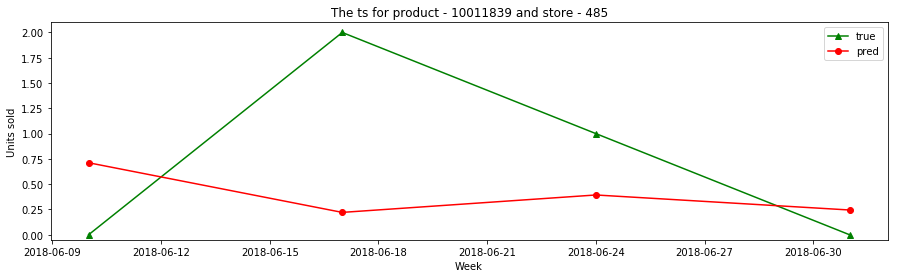

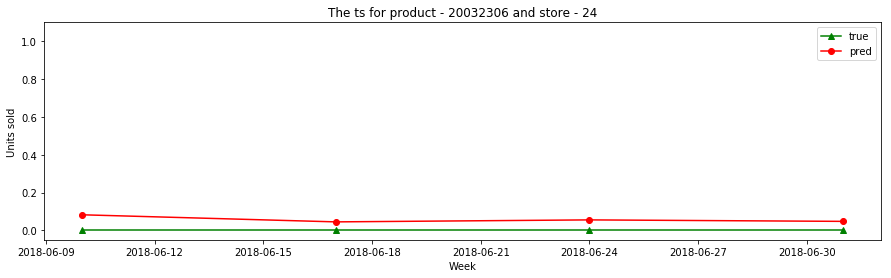

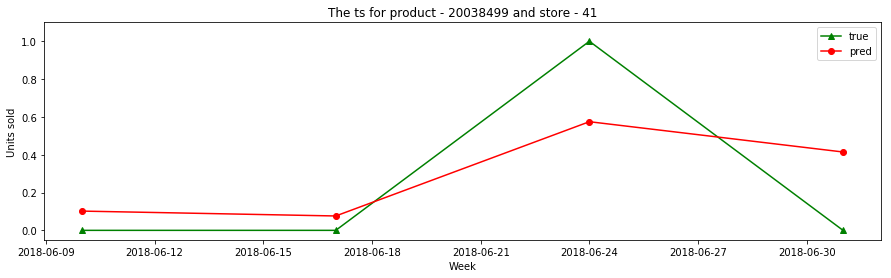

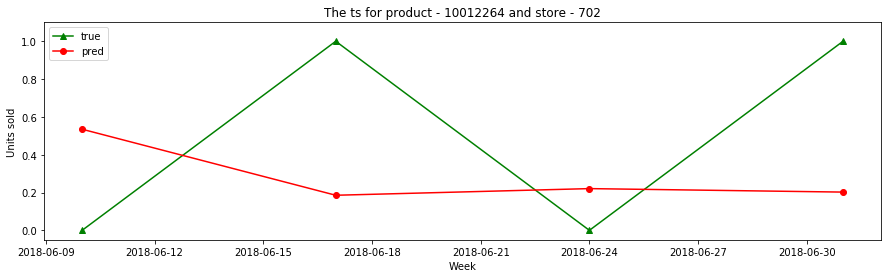

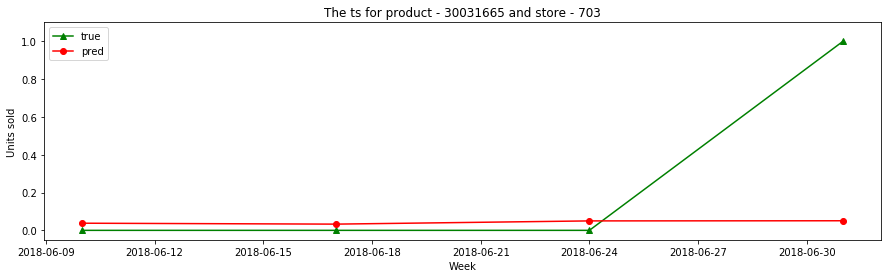

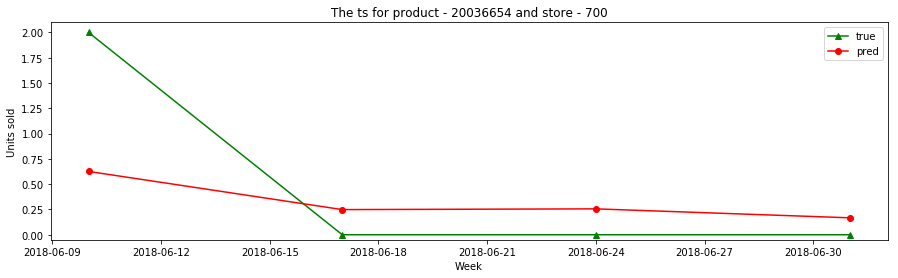

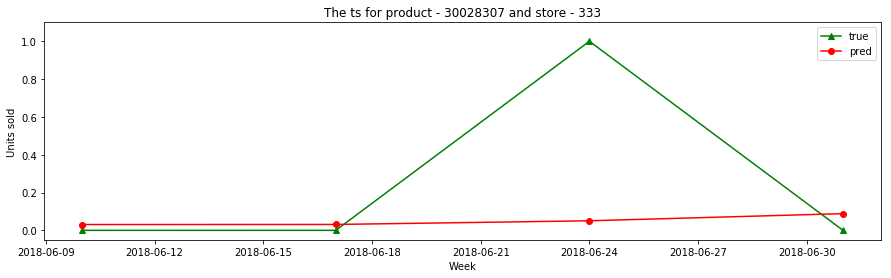

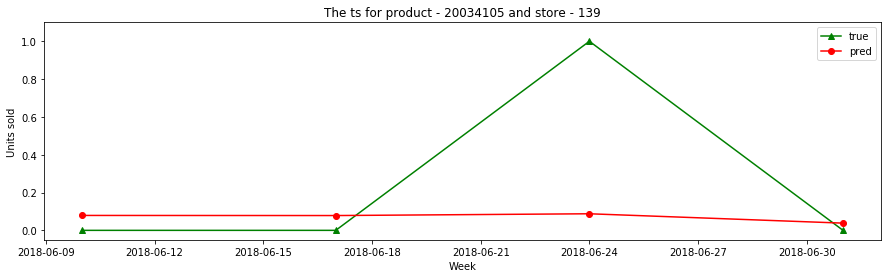

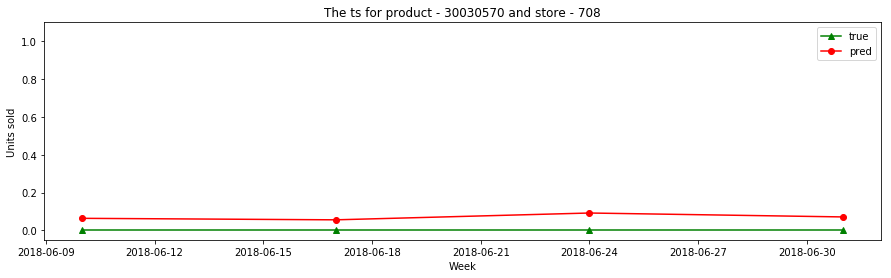

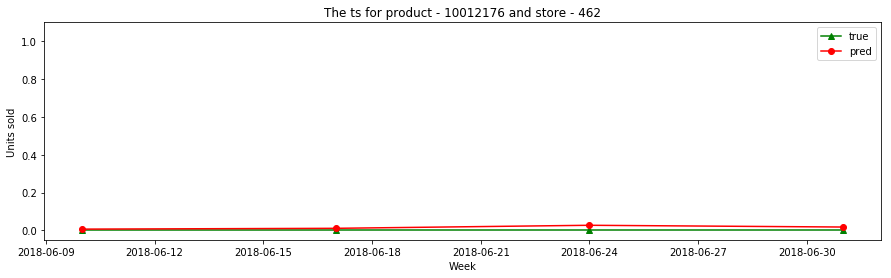

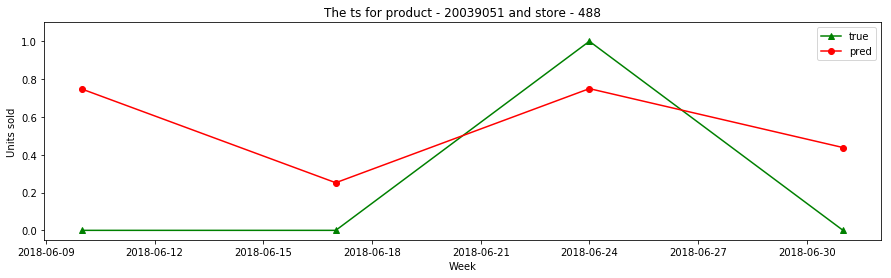

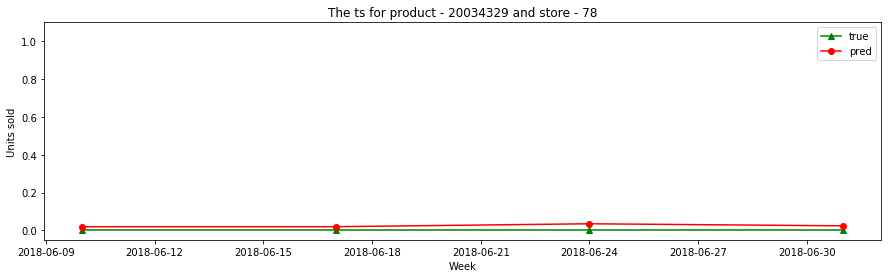

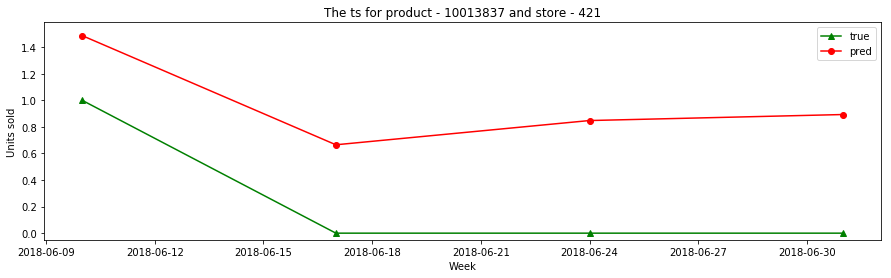

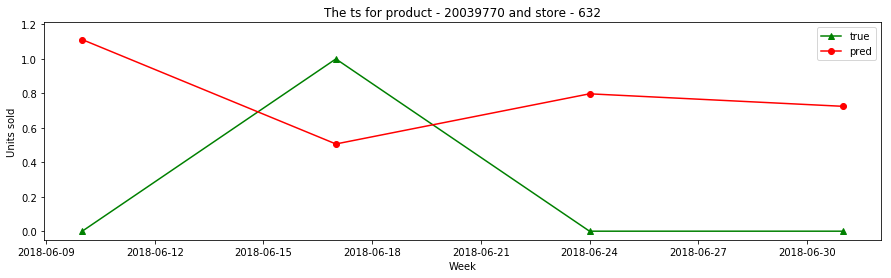

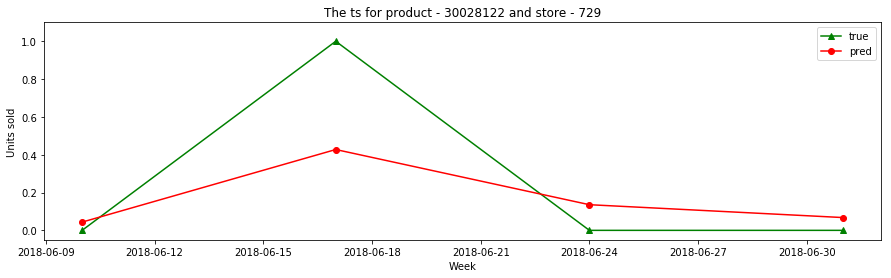

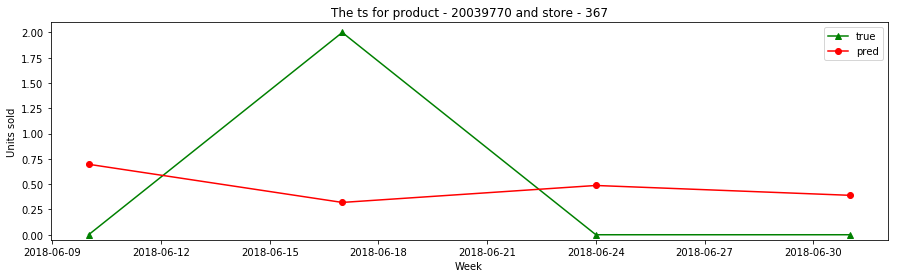

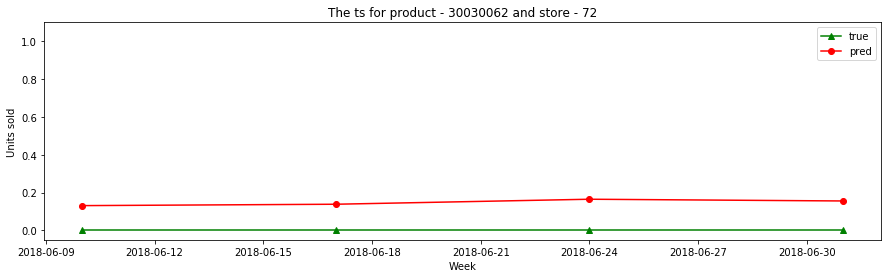

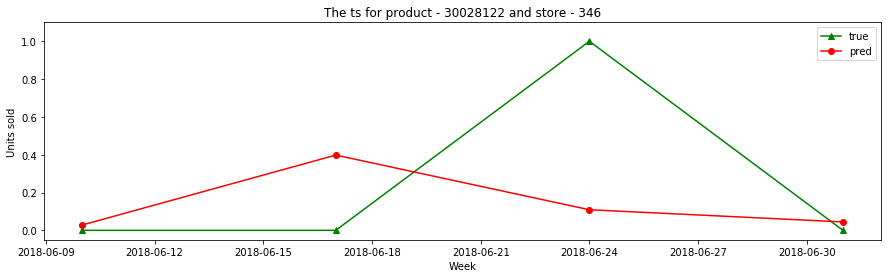

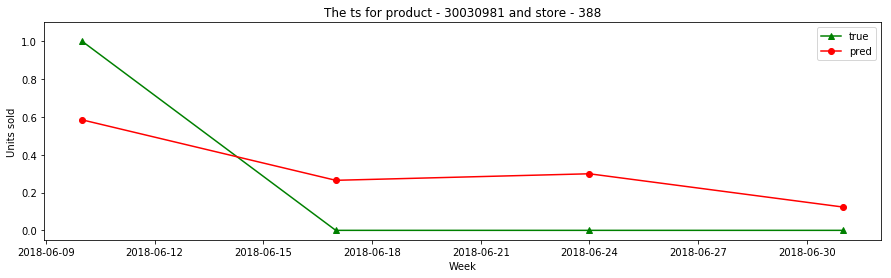

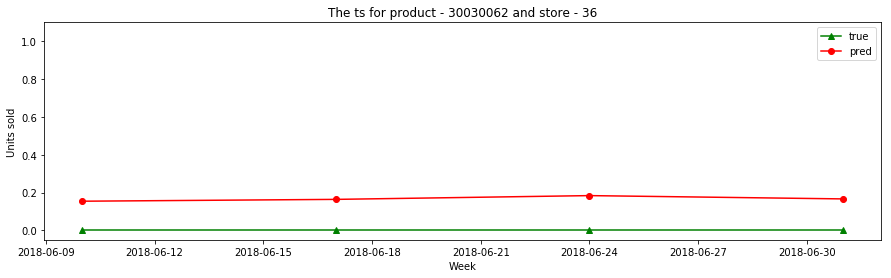

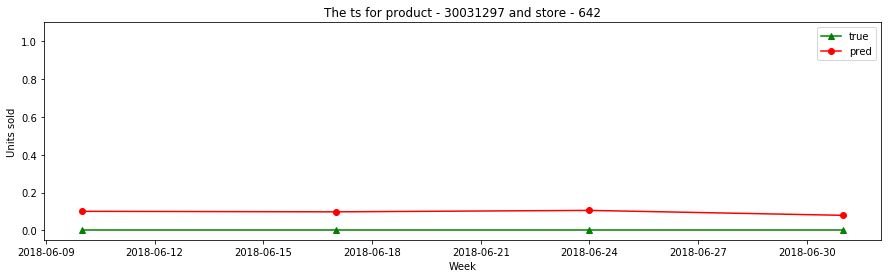

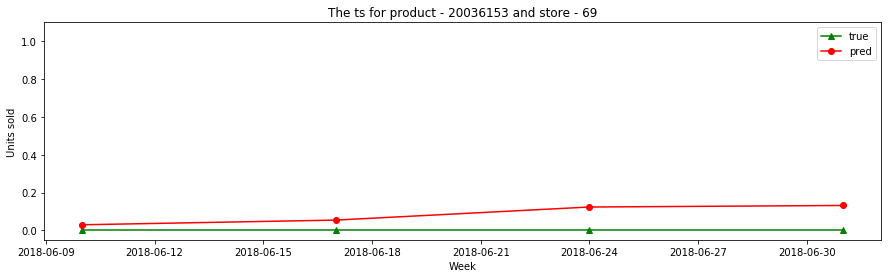

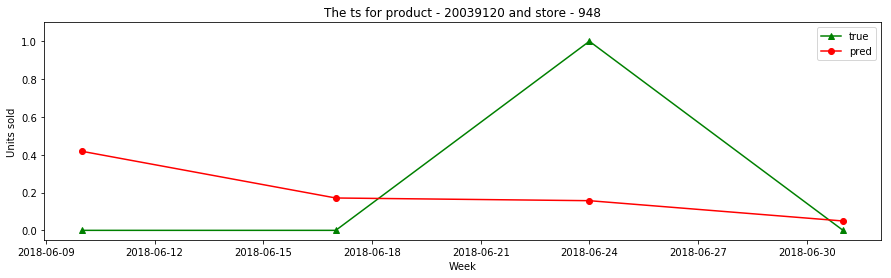

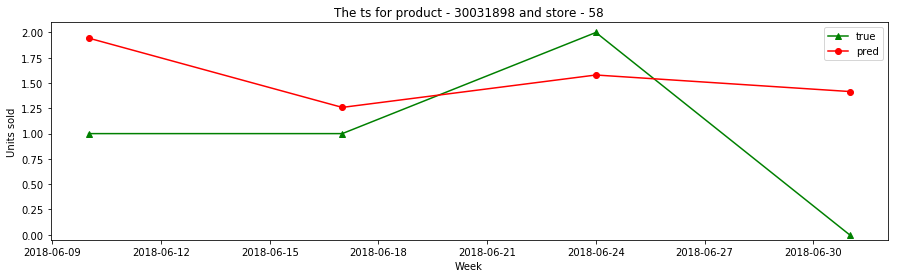

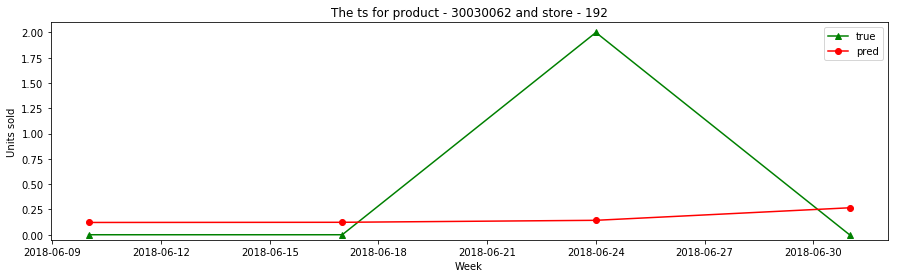

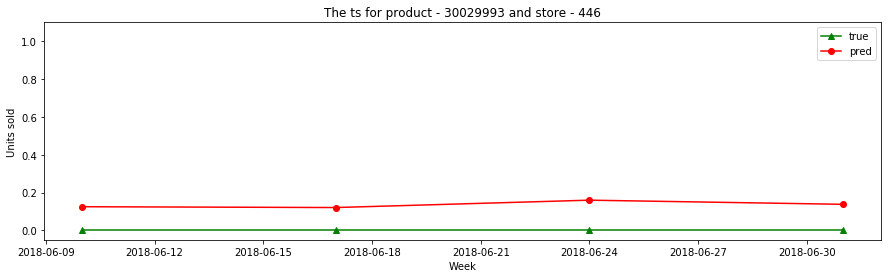

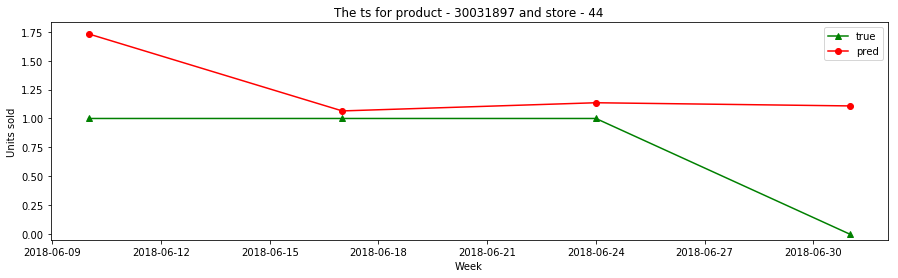

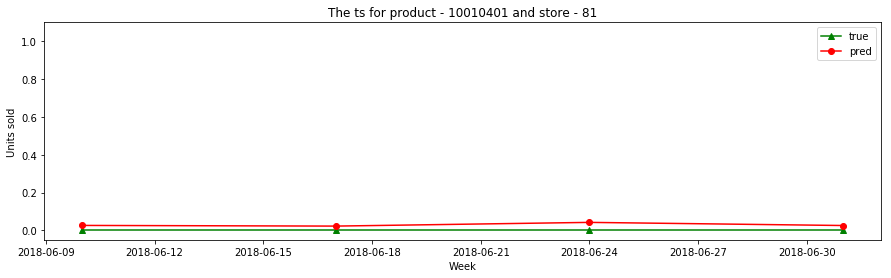

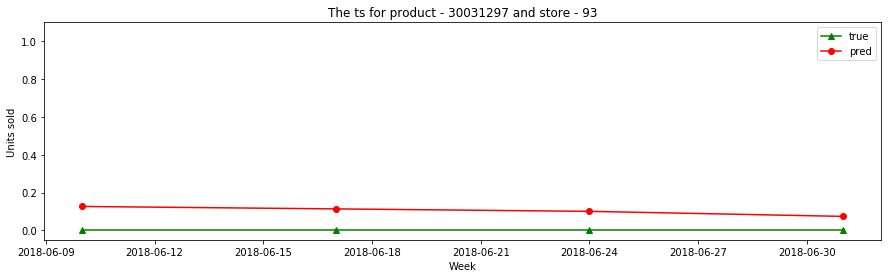

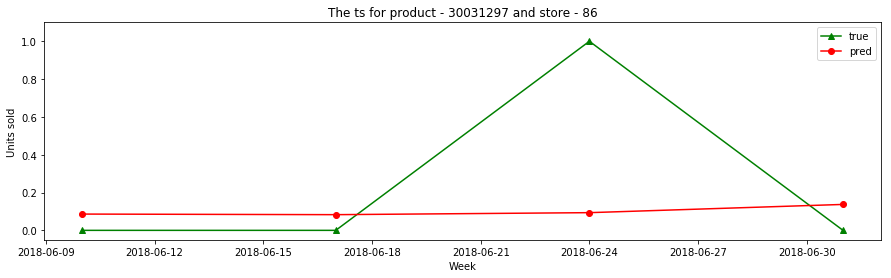

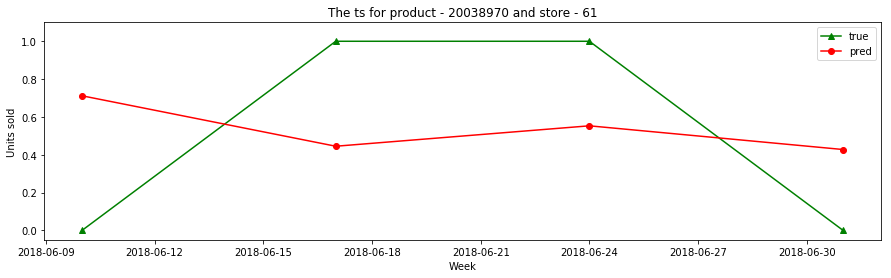

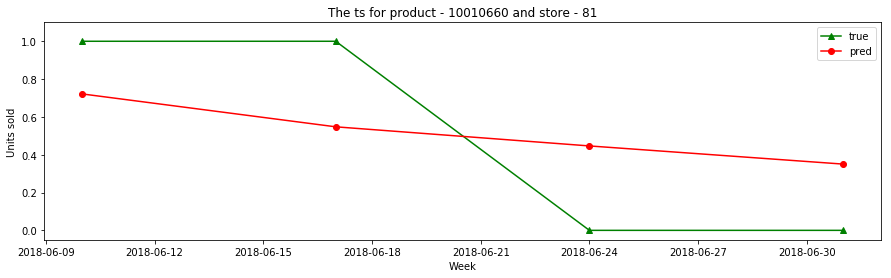

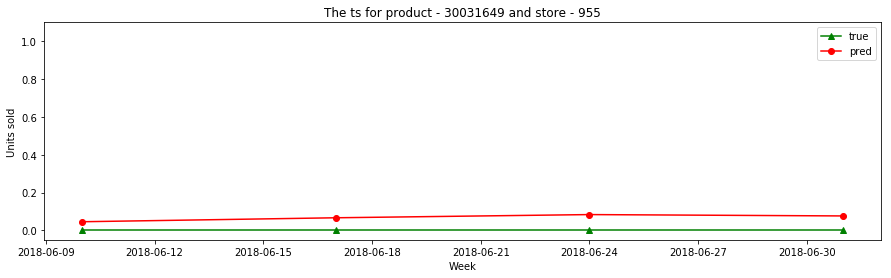

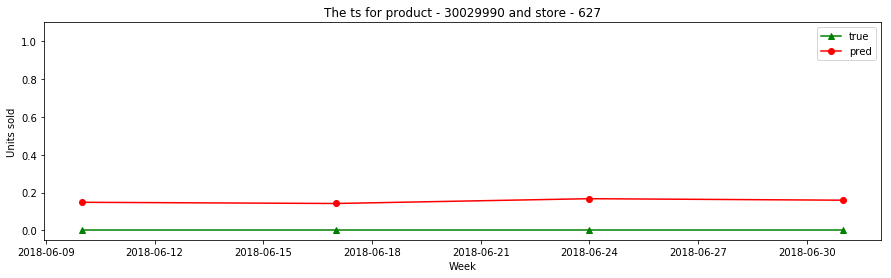

In [33]:
pairs = list(set(zip(res['STORE_ID'], res['PRODUCT_ID'])))

for i in range(len(pairs) // 1000):
    store_id, product_id = pairs[i]
    plot_ts(res, store_id, product_id)

In [34]:
dts2 = lgb.Dataset(data_train2[feat], label = data_train2.UNITS_SOLD_P1)

In [35]:
dts2 = dts2.construct()

In [36]:
bst.current_iteration()

986

In [37]:
bst2 = lgb.train(params, dts2, num_boost_round = bst.current_iteration())

In [38]:
bst2.save_model('/main/data/MVideo_2/lgb_7_w_1_full.txt')

In [39]:
#bst2 = lgb.Booster(model_file = '/main/data/MVideo_2/lgb_7_w_1_full.txt')

In [40]:
pred2 = bst2.predict(data_test[feat])

In [41]:
res = data_test[['PRODUCT_ID', 'STORE_ID']].copy()

In [42]:
res['PRED'] = pred2

In [43]:
res2 = pd.read_parquet('/main/data/MVideo_2/dataset_test_7.parquet')

In [44]:
res2 = res2[(res2.DATE == '2018-07-15')].copy()

In [45]:
res2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34790 entries, 0 to 34789
Data columns (total 3 columns):
STORE_ID      34790 non-null category
PRODUCT_ID    34790 non-null category
DATE          34790 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](1)
memory usage: 733.4 KB


In [46]:
res2 = res2.merge(res)

In [47]:
res2.PRED.clip(lower = 0, inplace = True)

In [48]:
res2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34790 entries, 0 to 34789
Data columns (total 4 columns):
STORE_ID      34790 non-null category
PRODUCT_ID    34790 non-null category
DATE          34790 non-null datetime64[ns]
PRED          34790 non-null float64
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 1005.2 KB


In [49]:
res2.to_parquet('/main/data/MVideo_2/results_7_w_1_full.parquet')

In [50]:
exp = shap.TreeExplainer(bst2)

In [51]:
shv = exp.shap_values(data_test[feat])

In [52]:
np.save('/main/data/MVideo_2/shv_7_w_1_full.npy', shv)

In [53]:
#shv = np.load('/main/data/MVideo_2/shv_7_w_1_full.npy')

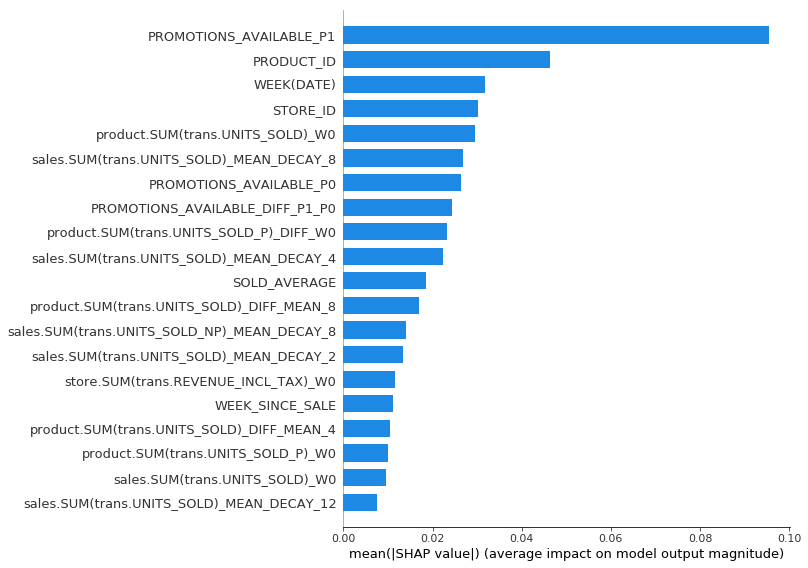

In [54]:
shap.summary_plot(shv, data_test[feat], plot_type="bar")

In [55]:
sc = np.mean(np.abs(shv), axis = 0)

In [56]:
score = pd.DataFrame(100 * sc / np.sum(sc),
                     index = bst2.feature_name(), columns = ['Score'])

In [57]:
score = score.sort_values('Score', ascending=False)

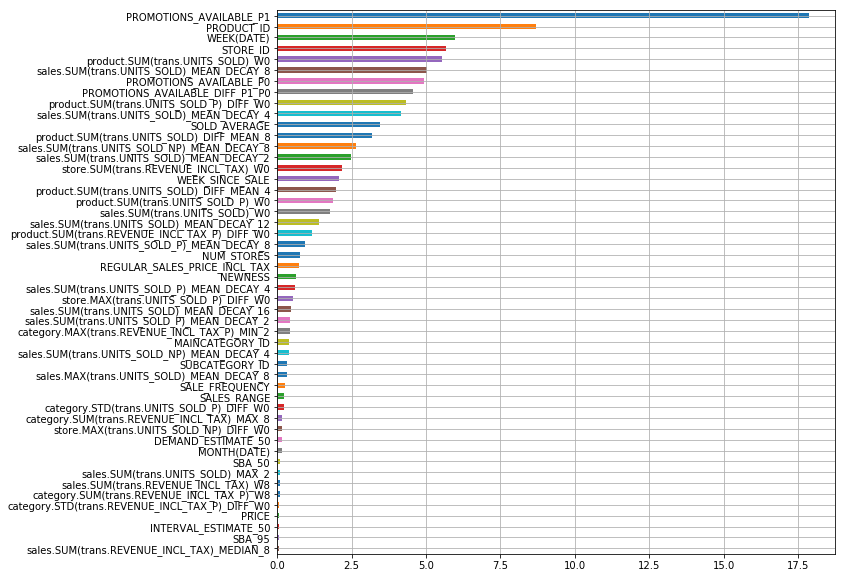

In [58]:
score.head(50).Score.plot.barh(grid=True, figsize=(10,10)).invert_yaxis()